In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = 'data/'
train_df = pd.read_json(data_path + 'train.json')
test_df = pd.read_json(data_path + 'test.json')

train_df.head()

,rating,title,text,helpful_vote,verified_purchase
0,1,"Bristles fall out, also very stiff",The boar bristles fall out. The plastic bristl...,0,True
1,3,Moldy tape,"I mean, 4 out of 6 tapes were alright… the oth...",3,True
2,5,Be prepared to wait,I did not like having to wait six months but t...,0,True
3,2,"Creases up terribly, but sparkly!","Pearly shine and lovely packaging. However, I ...",0,True
4,5,"Love these!! So pretty not too long, just wish...",Love these!! So pretty my favorite color & not...,0,True


In [3]:
def merge_title_text(df):
	text_list = []
	for title, text in zip(df['title'], df['text']):
		merged = title + ' ' + text
		text_list.append(merged)
	df = df.assign(merged=text_list)
	
	return df

In [4]:
train_df_merged = merge_title_text(train_df)
test_df_merged = merge_title_text(test_df)

print(train_df_merged.iloc[0]['merged'])

Bristles fall out, also very stiff The boar bristles fall out. The plastic bristles are so stiff that I am not convinced the boar bristles can even brush through my hair. I do not recommend!


In [5]:
train_list = list(train_df_merged['merged'])
train_rating = list(train_df_merged['rating'])
train_rating = [rating - 1 for rating in train_rating]

test_list = list(test_df_merged['merged'])

print(len(train_list))
print(train_rating[:10])

35000
[0, 2, 4, 1, 4, 0, 4, 3, 2, 4]


In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from transformers.models.bert.modeling_bert import BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report

In [7]:
class TextClassificationDataset(Dataset):
	def __init__(self, texts, labels, tokenizer, max_length):
		self.texts = texts
		self.labels = labels
		self.tokenizer = tokenizer
		self.max_length = max_length
  
	def __len__(self):
		return len(self.texts)
	
	def __getitem__(self, idx):
		text = self.texts[idx]
		label = self.labels[idx]
		encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
  
		return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [8]:
class BERTClassifier(nn.Module):
	def __init__(self, bert_model_name, num_classes):
		super(BERTClassifier, self).__init__()
		self.bert = BertModel.from_pretrained(bert_model_name)
		self.dropout = nn.Dropout(0.1)
		self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
		
	def forward(self, input_ids, attention_mask):
		outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
		pooled_output = outputs.pooler_output
		x = self.dropout(pooled_output)
		logits = self.fc(x)
  
		return logits

In [9]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [10]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [11]:
def predict_rating(model, data_loader, device):
	model.eval()
	predictions = []
	with torch.no_grad():
		for batch in data_loader:
			input_ids = batch['input_ids'].to(device)
			attention_mask = batch['attention_mask'].to(device)
			outputs = model(input_ids=input_ids, attention_mask=attention_mask)
			_, preds = torch.max(outputs, dim=1)
			preds = preds + 1
			predictions.extend(preds.cpu().tolist())
   
	return predictions

In [12]:
bert_model_name = 'bert-base-uncased'
num_classes = 5
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 1e-5

In [13]:
from transformers.models.bert.tokenization_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [14]:
from collections import Counter
import math

len_list = []
max_len = 0
span = 16
for text in train_list:
    length = len(tokenizer(text)['input_ids'])
    length = math.floor(length / span)
    max_len = max(max_len, length)
    len_list.append(length)
    
cnt = Counter(len_list)

Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors


In [15]:
print('Tokenized Sequence Length:')

total = 0
for key, value in sorted(cnt.items()):
    if(key >= 32):
        break
    total += value
    print(f'{key * span} - {(key + 1) * span - 1}: {value}')

print(f'{32 * span} or more: {len(train_list) - total}')

Tokenized Sequence Length:
0 - 15: 6196
16 - 31: 8458
32 - 47: 5927
48 - 63: 4150
64 - 79: 2681
80 - 95: 1795
96 - 111: 1277
112 - 127: 931
128 - 143: 648
144 - 159: 534
160 - 175: 413
176 - 191: 337
192 - 207: 231
208 - 223: 191
224 - 239: 156
240 - 255: 171
256 - 271: 124
272 - 287: 90
288 - 303: 97
304 - 319: 66
320 - 335: 63
336 - 351: 56
352 - 367: 41
368 - 383: 30
384 - 399: 42
400 - 415: 32
416 - 431: 22
432 - 447: 27
448 - 463: 18
464 - 479: 23
480 - 495: 14
496 - 511: 8
512 or more: 151


[Text(0, 0, '0'),
 Text(1, 0, '16'),
 Text(2, 0, '32'),
 Text(3, 0, '48'),
 Text(4, 0, '64'),
 Text(5, 0, '80'),
 Text(6, 0, '96'),
 Text(7, 0, '112'),
 Text(8, 0, '128'),
 Text(9, 0, '144'),
 Text(10, 0, '160'),
 Text(11, 0, '176'),
 Text(12, 0, '192'),
 Text(13, 0, '208'),
 Text(14, 0, '224'),
 Text(15, 0, '240'),
 Text(16, 0, '256'),
 Text(17, 0, '272'),
 Text(18, 0, '288'),
 Text(19, 0, '304'),
 Text(20, 0, '320'),
 Text(21, 0, '336'),
 Text(22, 0, '352'),
 Text(23, 0, '368'),
 Text(24, 0, '384'),
 Text(25, 0, '400'),
 Text(26, 0, '416'),
 Text(27, 0, '432'),
 Text(28, 0, '448'),
 Text(29, 0, '464'),
 Text(30, 0, '480'),
 Text(31, 0, '496'),
 Text(32, 0, '512')]

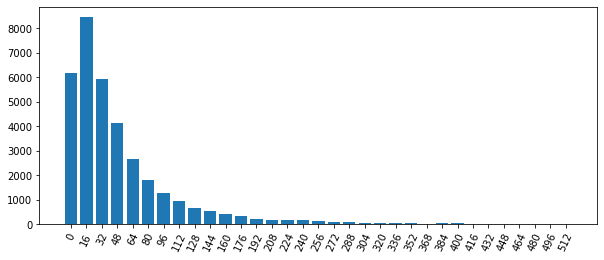

In [16]:
import matplotlib.pyplot as plt

count_list = []
for i in range(max_len + 1):
    count_list.append(cnt[i])
    
indices = np.arange(max_len + 1)
fig, ax = plt.subplots(figsize = (10,4))
ax.bar(indices[:33], count_list[:33])
ax.set_xticks(indices[:33])
ax.set_xticklabels(indices[:33] * span, rotation=65)

In [17]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(train_list, train_rating, test_size=0.1, random_state=31)

print(len(X_train), len(X_val))

31500 3500


In [18]:
train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_length)
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_list, [0] * len(test_list), tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [19]:
train_text_list = list(train_df['text'])
train_title_list = list(train_df['text'])
X_text_train, X_text_val, y_train, y_val = train_test_split(train_text_list, train_rating, test_size=0.1, random_state=31)
X_title_train, X_title_val, y_train, y_val = train_test_split(train_title_list, train_rating, test_size=0.1, random_state=31)

train_text_dataset = TextClassificationDataset(X_text_train, y_train, tokenizer, max_length)
val_text_dataset = TextClassificationDataset(X_text_val, y_val, tokenizer, max_length)
train_text_dataloader = DataLoader(train_text_dataset, batch_size=batch_size, shuffle=True)
val_text_dataloader = DataLoader(val_text_dataset, batch_size=batch_size)

train_title_dataset = TextClassificationDataset(X_title_train, y_train, tokenizer, max_length)
val_title_dataset = TextClassificationDataset(X_title_val, y_val, tokenizer, max_length)
train_title_dataloader = DataLoader(train_title_dataset, batch_size=batch_size, shuffle=True)
val_title_dataloader = DataLoader(val_title_dataset, batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
for epoch in range(num_epochs):
	print(f"Epoch {epoch + 1}/{num_epochs}")
	train(model, train_dataloader, optimizer, scheduler, device)
	accuracy, report = evaluate(model, val_dataloader, device)
	print(f"Validation Accuracy: {accuracy:.4f}")
	print(report)

In [ ]:
predict = predict_rating(model, test_dataloader, device)

indices = ['index_' + str(i) for i in range(len(predict))]
data = {"index": indices ,"rating": predict}
out_df = pd.DataFrame(data, columns=["index", "rating"])
out_df.to_csv('result.csv', index=False, header=True)

In [ ]:
model = BERTClassifier(bert_model_name, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_text_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_text_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

In [ ]:
model = BERTClassifier(bert_model_name, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_title_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_title_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)